### Demo of agentic RAG using Langgraph
This demo will outline the following items:
 - Fetch and preprocess documents that will be used for retrieval.
 - Index those documents for semantic search and create a retriever tool for the agent.
 - Build an agentic RAG system that can decide when to use the retriever tool.

Reference: [Langgraph agentic RAG](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/) 

#### Installs

In [1]:
# %%capture --no-stderr
# %pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

#### Imports

In [2]:
import pickle
from typing import List, Tuple, Dict, Any
import IPython.display as id
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from langchain_core.messages import convert_to_messages
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from pydantic import BaseModel, Field
from typing import Literal
from enum import Enum

USER_AGENT environment variable not set, consider setting it to identify your requests.


#### Global constants/variables

In [3]:
NEW_LINE = "\n"
LINE_DIVIDER = "==========" * 5
DOCUMENT_FOLDER_PATH = "./docs"
DOCUMENT_FILE_PATH = f"{DOCUMENT_FOLDER_PATH}/doc_pickle_data_file.pl"
os.makedirs(DOCUMENT_FOLDER_PATH, exist_ok=True)

#### Set Open AI key

In [4]:
_ = load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

#### Fetch documents

In [5]:
def getDocuments() -> List[Any]:
    """
    GFetch documents to use in our RAG system. 
    We will use three of the most recent pages from Lilian Weng's excellent blog.
    :return: List of documents
    """
    urls = [
        "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
        "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
        "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
    ]
    
    docs = [WebBaseLoader(url).load() for url in urls]
    return docs
    
def serializeDocsData(data):
    """
    Serialize the doc data
    :param data: Document data
    """
    with open(DOCUMENT_FILE_PATH, 'wb') as file:
        pickle.dump(data, file)

def deserializeDocsData() -> Any:
    """
    Serialize the doc data
    :return: Document data
    """
    with open(DOCUMENT_FILE_PATH, 'rb') as file:
        data = pickle.load(file)
    return data

def getCachedData():
    """
    Gets the documents from a pickle cache (if previously serialized
    else it gets it from the web and caches it for future use
    :return: Documents
    """
    if os.path.exists(DOCUMENT_FILE_PATH):
        print(f"Data found locally as pickle cache!!")
        docs = deserializeDocsData()        
    else:
        print(f"Data NOT found locally as pickle cache so is sourced from the web and cached for future use!!")
        docs = getDocuments()
        serializeDocsData(docs)
    return docs
        




docs = getCachedData()

Data found locally as pickle cache!!


#### Sample document content 

In [6]:
docs[0][0].page_content.strip()[:500]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking ex"

#### Chunk documents

In [7]:
def spliDocuments(docs: List[Any]) -> List[Any]:
    """
    Splits the documents into smaller chunks
    :param docs: Documents
    :return: Samller document chunks
    """
    docs_list = [item for sublist in docs for item in sublist]

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=100, chunk_overlap=50
    )
    doc_splits = text_splitter.split_documents(docs_list)
    return doc_splits

doc_chunks = spliDocuments(docs)

#### Sample document chunks

In [8]:
[doc_chunk.page_content.strip() for doc_chunk in doc_chunks[:2]]

["Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ",
 "Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng"]

#### Create the retriever tool

In [9]:
class RetrieverTool:
    """
    Retriever tool
    """
    def __init__(self, doc_chunks: List[Any]=doc_chunks):
        """
        Constructor
        :param doc_chunks: Document chunks
        """
        self.vectorstore = InMemoryVectorStore.from_documents(
            documents=doc_chunks, embedding=OpenAIEmbeddings()
        )
        self.retriever = self.vectorstore.as_retriever()

    def __call__(self):
        """
        Calls the instance of the Retriever tool
        """
        self.retriever_tool = create_retriever_tool(
            self.retriever,
            "retrieve_blog_posts",
            "Search and return information about Lilian Weng blog posts.",
        )
        return self.retriever_tool

#### Test the Retriever tool

In [10]:
retriever_tool = RetrieverTool(doc_chunks)
tool = retriever_tool()
print(type(tool))
query_sample = "types of reward hacking"
tool.invoke({"query": query_sample})

<class 'langchain_core.tools.simple.Tool'>


'Detecting Reward Hacking#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nWhy does Reward Hacking Exist?#'

#### Specify graph tasks factory class(i.e. thattasks can be graph nodes or edges)
This factory is used to create the task nodes that are part of the agentic workflow. These include:
 - task (node) to generate query or response
 - task (node) to retieve context
 - task (node) to re-write a question
 - task (node) to generate an answer
 - task (edge) to grade documents

##### Task enumerations

In [11]:
class TaskType(Enum):
    """
    Task enumerations
    """
    generate_query_or_response = 1
    retrieve_context = 2
    rewrite_question = 3
    generate_answer = 4
    grade_documents = 5

##### Implementation of the generate query or response tasks

In [12]:
class GenerateQueryOrResponseTask:
    """
    Implementation of the Document grading task
    """
    def __init__(self, retriever_tool: Any=tool):
        """
        Constructor
        :param retriever_tool: Context retriever tool
        """
        self.retriever_tool = retriever_tool
        self.response_model = init_chat_model("openai:gpt-4.1", temperature=0)

    def _generate_query_or_respond(self, state: MessagesState):
        """Call the model to generate a response based on the current state. Given
        the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
        """
        response = (
            self.response_model
            .bind_tools([self.retriever_tool]).invoke(state["messages"])
        )
        return {"messages": [response]}

    def __call__(self, state: MessagesState):
        """
        Calls the instance of the "GenerateQueryOrResponseTask"
        """
        return self._generate_query_or_respond(state)
        
        
        
    

##### Implementation of the Document grading task

In [13]:
class GradeDocuments(BaseModel):
    """
    Grade documents (pydantic object) using a binary score for relevance check.
    """

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


In [14]:
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


In [15]:
class DocumentsGradingTask:
    """
    Implementation of the generate query or response node
    """
    def __init__(self):
        """
        Constructor        
        """        
        self.grader_model = init_chat_model("openai:gpt-4.1", temperature=0)
        self.grade_documents = GradeDocuments

    def _gradeDocuments(
        self, 
        state: MessagesState,
        ) -> Literal["generate_answer", "rewrite_question"]:
        """Determine whether the retrieved documents are relevant to the question."""
        question = state["messages"][0].content
        context = state["messages"][-1].content
    
        prompt = GRADE_PROMPT.format(question=question, context=context)
        response = (
            self.grader_model
            .with_structured_output(self.grade_documents).invoke(
                [{"role": "user", "content": prompt}]
            )
        )
        score = response.binary_score
    
        if score == "yes":
            return "generate_answer"
        else:
            return "rewrite_question"

    def __call__(self, state: MessagesState):
        """
        Calls the instance of the "DocumentsGradingTask"
        """
        return self._gradeDocuments(state)
        

#### Implementation of the Re-write question task

In [16]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

In [17]:
class RewriteQuestionTask:
    """
    Implementation of the rewrite question task
    """
    def __init__(self):
        """
        Constructor        
        """
        self.response_model = init_chat_model("openai:gpt-4.1", temperature=0)

    def _rewriteQuestion(self, state: MessagesState):
        """
        Rewrite the original user question.
        :param state: State
        """
        messages = state["messages"]
        question = messages[0].content
        prompt = REWRITE_PROMPT.format(question=question)
        response = self.response_model.invoke([{"role": "user", "content": prompt}])
        return {"messages": [{"role": "user", "content": response.content}]}

    def __call__(self, state: MessagesState):
        """
        Calls the instance of the "GenerateQueryOrResponseTask"
        """
        return self._rewriteQuestion(state)


#### Implementation of the Generate an answer task 

In [18]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

In [19]:
class GenerateAnswerTask:
    """
    Implementation of the Generate an answer task 
    """
    def __init__(self):
        """
        Constructor        
        """
        self.response_model = init_chat_model("openai:gpt-4.1", temperature=0)

    def _generateAnswer(self, state: MessagesState):
        """
        Rewrite the original user question.
        :param state: State
        """
        question = state["messages"][0].content
        context = state["messages"][-1].content
        prompt = GENERATE_PROMPT.format(question=question, context=context)
        response = self.response_model.invoke([{"role": "user", "content": prompt}])
        return {"messages": [response]}

    def __call__(self, state: MessagesState):
        """
        Calls the instance of the "GenerateAnswerTask"
        """
        return self._generateAnswer(state)


In [20]:
class TaskFactory:
    """
    Factory is used to create the task nodes that are part of the agentic workflow
    """
    @staticmethod        
    def create(task_type: TaskType, retriever_tool: Any=tool):
        """
        Calls the factory instance
        :param task_type: Task type
        """
        tasks = {
            TaskType.generate_query_or_response: GenerateQueryOrResponseTask(retriever_tool),
            TaskType.retrieve_context: retriever_tool,
            TaskType.grade_documents: DocumentsGradingTask(),
            TaskType.rewrite_question: RewriteQuestionTask(),
            TaskType.generate_answer: GenerateAnswerTask(),
        }
        selected_task = tasks.get(task_type)
        return selected_task

#### Test the node factory

In [21]:
def testGenerateQueryOrResponseTask():
    """
    Test the "GenerateQueryOrResponseTask"
    """
    task_type=TaskType.generate_query_or_response
    task = TaskFactory.create(task_type)    

    print("Results for random query:")
    input_random = {"messages": [{"role": "user", "content": "hello!"}]}
    task(input_random)["messages"][-1].pretty_print()
    print(f"{NEW_LINE}")

    print("Results for query with semantic search:")
    input_with_semantic_search = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
        ]
    }
    task(input_with_semantic_search)["messages"][-1].pretty_print()
    print(f"{NEW_LINE}")

def testRetrieverToolTask():
    """
    Test the "RetrieverToolTask"
    """
    task_type=TaskType.retrieve_context
    task = TaskFactory.create(task_type)
    # retriever_tool = RetrieverTool(doc_chunks)
    # tool = retriever_tool()
    print(type(task))
    
    query_sample = "types of reward hacking"
    print(task.invoke({"query": query_sample}))

def testDocumentsGradingTask():
    """
    Test the "DocumentsGradingTask"
    """
    task_type=TaskType.grade_documents
    task = TaskFactory.create(task_type)

    input_irrelevant_docs = {
    "messages": convert_to_messages(
        [
                {
                    "role": "user",
                    "content": "What does Lilian Weng say about types of reward hacking?",
                },
                {
                    "role": "assistant",
                    "content": "",
                    "tool_calls": [
                        {
                            "id": "1",
                            "name": "retrieve_blog_posts",
                            "args": {"query": "types of reward hacking"},
                        }
                    ],
                },
                {"role": "tool", "content": "meow", "tool_call_id": "1"},
            ]
        )
    }
    print(task(input_irrelevant_docs))

    input_relevant_docs = {
    "messages": convert_to_messages(
            [
                {
                    "role": "user",
                    "content": "What does Lilian Weng say about types of reward hacking?",
                },
                {
                    "role": "assistant",
                    "content": "",
                    "tool_calls": [
                        {
                            "id": "1",
                            "name": "retrieve_blog_posts",
                            "args": {"query": "types of reward hacking"},
                        }
                    ],
                },
                {
                    "role": "tool",
                    "content": "At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                    "tool_call_id": "1",
                },
            ]
        )
    }
    print(task(input_relevant_docs))

def testRewriteQuestionTaskTask():
    """
    Test the "RewriteQuestionTask"
    """
    task_type=TaskType.rewrite_question
    task = TaskFactory.create(task_type)   

    input = {
    "messages": convert_to_messages(
            [
                {
                    "role": "user",
                    "content": "What does Lilian Weng say about types of reward hacking?",
                },
                {
                    "role": "assistant",
                    "content": "",
                    "tool_calls": [
                        {
                            "id": "1",
                            "name": "retrieve_blog_posts",
                            "args": {"query": "types of reward hacking"},
                        }
                    ],
                },
                {"role": "tool", "content": "meow", "tool_call_id": "1"},
            ]
        )
    }

    print(task(input)["messages"][-1]["content"])
    print(f"{NEW_LINE}")

def testGenerateAnswerTask():
    """
    Test the "RewriteQuestionTask"
    """
    task_type=TaskType.generate_answer
    task = TaskFactory.create(task_type)   

    input = {
    "messages": convert_to_messages(
            [
                {
                    "role": "user",
                    "content": "What does Lilian Weng say about types of reward hacking?",
                },
                {
                    "role": "assistant",
                    "content": "",
                    "tool_calls": [
                        {
                            "id": "1",
                            "name": "retrieve_blog_posts",
                            "args": {"query": "types of reward hacking"},
                        }
                    ],
                },
                {
                    "role": "tool",
                    "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                    "tool_call_id": "1",
                },
            ]
        )
    }

    print(task(input)["messages"][-1].pretty_print())
    print(f"{NEW_LINE}")

    
print(f"testGenerateQueryOrResponseTask(): ")
testGenerateQueryOrResponseTask()
print(f"{LINE_DIVIDER}{NEW_LINE}{NEW_LINE}")

print(f"testRetrieverToolTask(): ")
testRetrieverToolTask()
print(f"{LINE_DIVIDER}{NEW_LINE}{NEW_LINE}")

print(f"testDocumentsGradingTask(): ")
testDocumentsGradingTask()
print(f"{LINE_DIVIDER}{NEW_LINE}{NEW_LINE}")

print(f"testRewriteQuestionTaskTask(): ")
testRewriteQuestionTaskTask()
print(f"{LINE_DIVIDER}{NEW_LINE}{NEW_LINE}")

print(f"testGenerateAnswerTask(): ")
testGenerateAnswerTask()
print(f"{LINE_DIVIDER}{NEW_LINE}{NEW_LINE}")

testGenerateQueryOrResponseTask(): 
Results for random query:
================================== Ai Message ==================================

Hello! How can I help you today?


Results for query with semantic search:
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_ewJpz31kHih5lQlYKOnvUgtb)
 Call ID: call_ewJpz31kHih5lQlYKOnvUgtb
  Args:
    query: types of reward hacking




testRetrieverToolTask(): 
<class 'langchain_core.tools.simple.Tool'>
Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Why does Reward Hacking Exist?#


testDocumentsGradingTask(): 
rewrite_question
generate_answer


testRewriteQuestionTaskTask(

#### Assemble the langgraph workflow graph
Graph workflow consist of the steps:
 - Start with a GenerateQueryOrResponseTask() task and determine if we need to call RetrieverToolTask()
 - Route to next step using tools_condition (this is a prebuilt task in the langgraph framework):
   - If GenerateQueryOrResponseTask() returned tool_calls then the RetrieverToolTask() will be invoked
   - Else the bot will respond directly to the user
 - Invoke the DocumentsGradingTask() to grade retrieved document content for relevance to the question and route to next step:
   - If document context is NOT relevant, invoke the RewriteQuestionTaskTask() to rewrite the question and then call GenerateQueryOrResponseTask() again
   - If document context is relevant, proceed to invoke the GenerateAnswerTask() and generate final response using the ToolMessage with the retrieved document context

In [22]:
# def grade_documents(
#     state: MessagesState,
# ) -> Literal["generate_answer", "rewrite_question"]:
#    """Determine whether the retrieved documents are relevant to the question."""
#    return TaskFactory.create(TaskType.grade_documents)

grader_model = init_chat_model("openai:gpt-4.1", temperature=0)

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

class RagWorkflow:
    """
    Assembles the agentic langgraph RAG workflow graph
    """
    def __init__(self):
        """
        Constructor
        """
        self.workflow = StateGraph(MessagesState)
        self.generate_query_or_respond = TaskFactory.create(TaskType.generate_query_or_response) 
        self.retriever_tool = TaskFactory.create(TaskType.retrieve_context)
        self.rewrite_question = TaskFactory.create(TaskType.rewrite_question)   
        self.generate_answer = TaskFactory.create(TaskType.generate_answer)
        # self.grade_documents = grade_documents_wrapper_func

        self.graph = None

    def createWorflowGraph(self):
        """
        Creates the workflow
        """
        # Define the nodes we will cycle between
        self.workflow.add_node("generate_query_or_respond", self.generate_query_or_respond)
        self.workflow.add_node("retrieve", ToolNode([self.retriever_tool]))
        self.workflow.add_node("rewrite_question", self.rewrite_question)
        self.workflow.add_node("generate_answer", self.generate_answer)

        
        # Add the 1st edge
        self.workflow.add_edge(START, "generate_query_or_respond")
        
        # Decide whether to retrieve using a conditional edge
        self.workflow.add_conditional_edges(
            "generate_query_or_respond",
            # Assess LLM decision (call `retriever_tool` tool or respond to the user)
            tools_condition,
            {
                # Translate the condition outputs to nodes in our graph
                "tools": "retrieve",
                END: END,
            },
        )
        

        # Add edges taken after the `action` node is called.
        self.workflow.add_conditional_edges(
            "retrieve",
            # Assess agent decision
            grade_documents,
        )

        # self.workflow.add_edge("retrieve", "rewrite_question")
        self.workflow.add_edge("rewrite_question", "generate_query_or_respond")
        # self.workflow.add_edge("retrieve", "generate_answer")
        self.workflow.add_edge("generate_answer", END)

        # Compile
        self.graph = self.workflow.compile()
        return self.graph

    def visualize(self):
        """
        Visualize the workflow graph
        """
        display(Image(self.graph.get_graph().draw_mermaid_png()))
    

#### Build and visualize the workflow graph

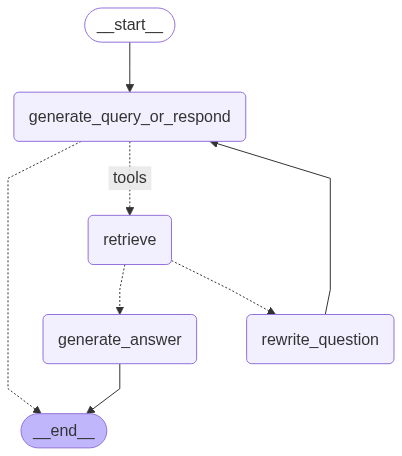

In [23]:
def buildAndVisualizeWorflow() -> CompiledStateGraph:
    """
    Build and generates the visualization of the agentic workflow
    :return: Built worflow graph
    """
    rag_worflow = RagWorkflow()
    graph = rag_worflow.createWorflowGraph()
    rag_worflow.visualize()
    
    return graph

graph = buildAndVisualizeWorflow()

#### Run the agentic RAG

In [24]:
def runDemo(graph: CompiledStateGraph):
    """
    Runs the agentic RAG demo
    :param graph: Complied state graph
    """
    user_query = {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
    for chunk in graph.stream(user_query):
        for node, update in chunk.items():
            print("Update from node", node)
            update["messages"][-1].pretty_print()
            print("\n\n")

runDemo(graph)

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_mS3NzUkMYb7qay2M27C8VqDm)
 Call ID: call_mS3NzUkMYb7qay2M27C8VqDm
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Why does Reward Hacking Exist?#



Update from node generate_answer
================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecificat